In [1]:
import numpy as np
import time
from datetime import datetime
# import pycuda stuff
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

In [2]:
def run_test(n, BLOCK_SIZE):
    ni = np.int32(n)

    # matrix A
    a = np.random.randn(n, n)*100
    a = a.astype(np.float32)
    
    # matrix B
    b = np.random.randn(n, n)*100
    b = b.astype(np.float32)
    
    # matrix B
    c = np.empty([n, n])
    c = c.astype(np.float32)
    
    # allocate memory on device
    a_gpu = cuda.mem_alloc(a.nbytes)
    b_gpu = cuda.mem_alloc(b.nbytes)
    c_gpu = cuda.mem_alloc(c.nbytes)
    
    # copy matrix to memory
    cuda.memcpy_htod(a_gpu, a)
    cuda.memcpy_htod(b_gpu, b)
    
    # compile kernel
    mod = SourceModule(open("kernels.cu", "r").read())
    
    # get function
    matmul = mod.get_function("matmul")
    
    
    # set grid size
    if (n % BLOCK_SIZE) != 0:
        grid = (n // BLOCK_SIZE + 1, n // BLOCK_SIZE + 1, 1)
    else:
        grid = (n // BLOCK_SIZE, n // BLOCK_SIZE, 1)
    
    # call gpu function
    start_d = datetime.now()
    matmul(ni, a_gpu, b_gpu, c_gpu, block=(BLOCK_SIZE, BLOCK_SIZE, 1), grid=grid)
    gpu_time = (datetime.now() - start_d).microseconds
    # print(gpu_time)
    
    # copy back the result
    cuda.memcpy_dtoh(c, c_gpu)
    
    
    # check cpu time exec
    start_d = datetime.now()
    cpu_res = np.dot(a, b)
    cpu_time = (datetime.now() - start_d).microseconds
    
    # relative variance of difference
    rel_var = np.var(c - cpu_res) / np.var(a)
    
    return gpu_time, cpu_time, rel_var

In [3]:
hist = {
    "n": [],
    "gpu": [],
    "cpu": [],
    "var": []
}

In [4]:
test_size = 100
for n in np.logspace(2, 10, num=100, base=2):
    test_avg = {
        "gpu": [],
        "cpu": [],
        "var": []
    }
    for i in range(test_size):
        gpu_time, cpu_time, rel_var = run_test(int(n), 16)
        test_avg["gpu"].append(gpu_time)
        test_avg["cpu"].append(cpu_time)
        test_avg["var"].append(rel_var)
    
    hist["n"].append(n)
    hist["gpu"].append(sum(test_avg["gpu"]) / len(test_avg["gpu"]))
    hist["cpu"].append(sum(test_avg["cpu"]) / len(test_avg["cpu"]))
    hist["var"].append(sum(test_avg["var"]) / len(test_avg["var"]))
    
    # n *= 2

C:\Users\McGrisha\AppData\Local\Temp\ipykernel_7676\25916125.py:14: RuntimeWarning: overflow encountered in cast
  c = c.astype(np.float32)


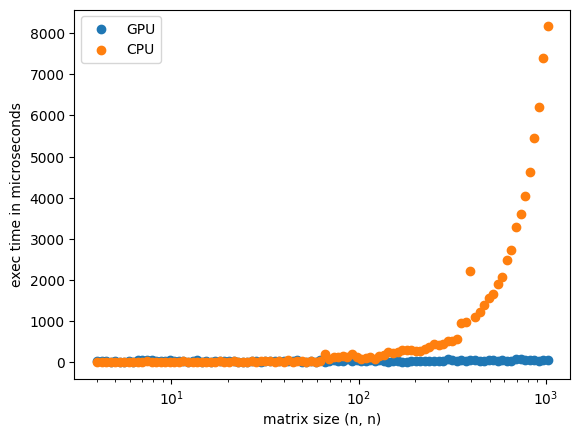

In [5]:

import matplotlib.pyplot as plt
plt.scatter(hist["n"], hist["gpu"], label="GPU")
plt.scatter(hist["n"], hist["cpu"], label="CPU")
plt.xscale("log")
plt.ylabel("exec time in microseconds")
plt.xlabel("matrix size (n, n)")
# plt.yscale("log")
plt.legend()
plt.show()

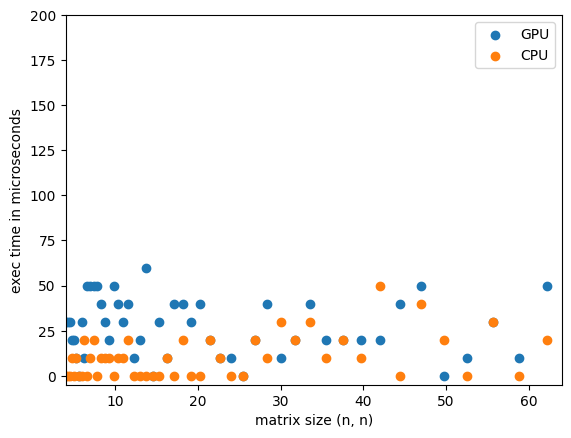

In [6]:
plt.scatter(hist["n"], hist["gpu"], label="GPU")
plt.scatter(hist["n"], hist["cpu"], label="CPU")
plt.xlim([4, 64])
plt.ylim([-5, 200])
plt.ylabel("exec time in microseconds")
plt.xlabel("matrix size (n, n)")
# plt.yscale("log")
plt.legend()
plt.show()

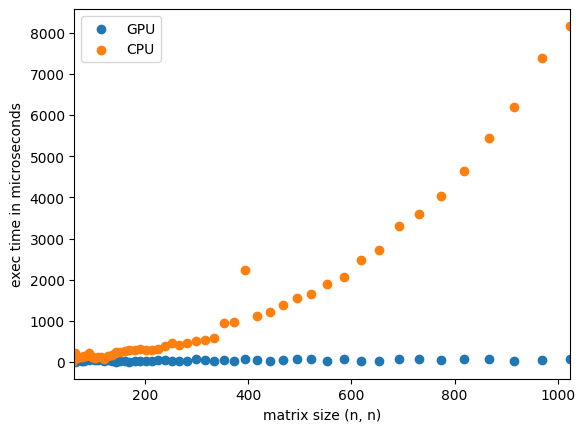

In [7]:
plt.scatter(hist["n"], hist["gpu"], label="GPU")
plt.scatter(hist["n"], hist["cpu"], label="CPU")
plt.xlim([64, 1<<10])
plt.ylabel("exec time in microseconds")
plt.xlabel("matrix size (n, n)")
# plt.yscale("log")
plt.legend()
plt.show()

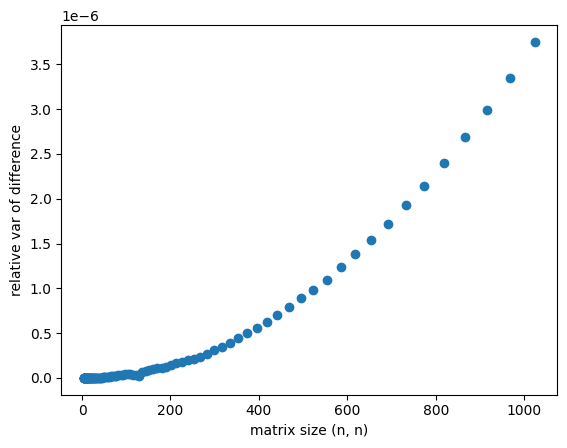

In [8]:
plt.scatter(hist["n"], hist["var"])
plt.ylabel("relative var of difference")
plt.xlabel("matrix size (n, n)")
# plt.yscale("log")
plt.show()

In [9]:
from itertools import product

nums = np.logspace(2, 10, num=50, base=2)
blocks = [2, 4, 8, 16, 32]

hist_blocks = []

for n, block_size in product(nums, blocks):
    # print(n, block_size)
    if (int(n) <= block_size):
        continue
    try:
        test_avg = {
            "gpu": [],
            "cpu": [],
            "var": []
        }
        for i in range(test_size):
            gpu_time, cpu_time, rel_var = run_test(int(n), block_size)
            test_avg["gpu"].append(gpu_time)
            test_avg["cpu"].append(cpu_time)
            test_avg["var"].append(rel_var)
        
        hist_blocks.append((n, 
                            block_size, 
                            sum(test_avg["gpu"]) / len(test_avg["gpu"]),
                            sum(test_avg["cpu"]) / len(test_avg["cpu"]),
                            sum(test_avg["var"]) / len(test_avg["var"])
                            ))
    except:
        print("BEBRA", n, block_size)

C:\Users\McGrisha\AppData\Local\Temp\ipykernel_7676\25916125.py:14: RuntimeWarning: overflow encountered in cast
  c = c.astype(np.float32)


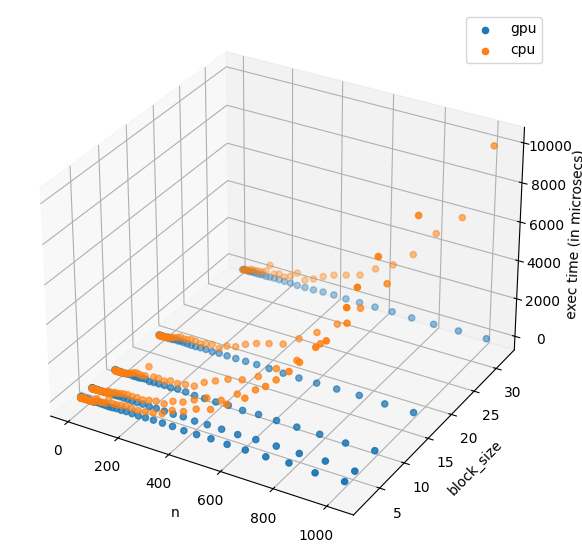

In [13]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 7))
ax_3d = fig.add_subplot(projection='3d')

ax_3d.scatter(
    np.array([x[0] for x in hist_blocks]),  # n
    np.array([x[1] for x in hist_blocks]),  # block_size
    np.array([x[2] for x in hist_blocks]),  # gpu_time
    label="gpu"
)

ax_3d.scatter(
    np.array([x[0] for x in hist_blocks]),  # n
    np.array([x[1] for x in hist_blocks]),  # block_size
    np.array([x[3] for x in hist_blocks]),  # gpu_time
    label="cpu"
)

ax_3d.set_xlabel('n')
ax_3d.set_ylabel('block_size')
ax_3d.set_zlabel('exec time (in microsecs)')

plt.legend()
plt.show()


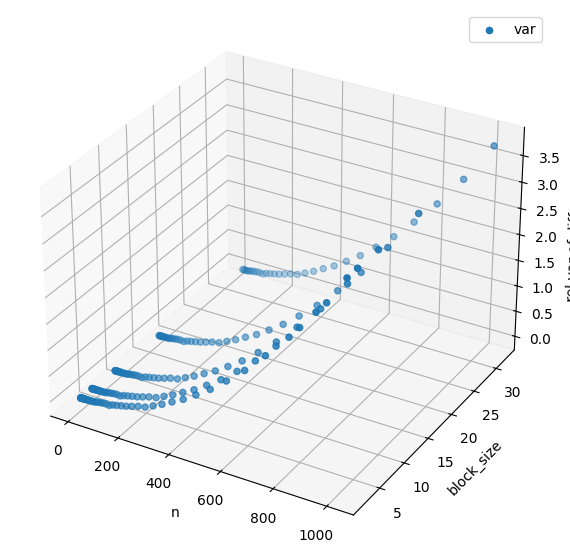

In [20]:
fig = plt.figure(figsize=(7, 7))
ax_3d = fig.add_subplot(projection='3d')

ax_3d.scatter(
    np.array([x[0] for x in hist_blocks]),  # n
    np.array([x[1] for x in hist_blocks]),  # block_size
    np.array([x[4] for x in hist_blocks]),  # var
    label="var"
)

ax_3d.set_xlabel('n')
ax_3d.set_ylabel('block_size')
ax_3d.set_zlabel('rel var of difference')
plt.legend()
plt.show()

